In [51]:
%%writefile README.md

# Predictive Analytics for Early Diabetes Diagnosis

**Goal:** Build and compare ML models to predict diabetes from clinical indicators (Pima Indians Dataset).
**Highlights:** End-to-end pipeline (cleaning → EDA → baselines → tuning → comparison) with reproducible code.

## Dataset
Pima Indians Diabetes (UCI/Kaggle).
**Target:** `Outcome` (1=diabetes, 0=non-diabetes)
**Features:** Pregnancies, Glucose, BloodPressure, SkinThickness, Insulin, BMI, DiabetesPedigreeFunction, Age.
**Note:** Zeros in some medical features are invalid → treated as missing and imputed (median).

## Methods
- Train/test split (80/20, stratified)
- Scaling for LR/KNN; trees used raw features
- Models: Logistic Regression, KNN, Decision Tree, Random Forest, XGBoost
- Metrics: Accuracy, Precision, Recall, F1, ROC-AUC
- Improvements: class weights (`balanced`) + GridSearchCV for KNN/RF/XGB

## Results
| Model                        | Accuracy | Precision | Recall | F1 Score | ROC AUC |
|------------------------------|----------|-----------|--------|----------|---------|
| **XGBoost (Tuned)**          | 0.734    | 0.644     | 0.537  | 0.586    | **0.818** |
| Balanced Logistic Regression | 0.734    | 0.603     | **0.704** | **0.650** | 0.813 |
| Random Forest (Tuned)        | 0.740    | 0.667     | 0.519  | 0.583    | 0.810 |
| KNN (Tuned)                  | **0.760**| **0.698** | 0.556  | 0.619    | 0.807 |

**Best by ROC-AUC:** XGBoost (0.818).
**Best Recall:** Balanced Logistic Regression (0.704).
**Best Accuracy:** KNN (0.760).

## Key Insights
- **Glucose** is the strongest predictor of diabetes, followed by **BMI** and **Age**.
- Models show different trade-offs:
  - XGBoost gives the best ROC-AUC (overall discrimination).
  - Balanced Logistic Regression gives the highest Recall (catching more diabetic cases).
  - KNN slightly outperforms others in raw Accuracy.
- In a healthcare context, Recall is often more critical than Accuracy.

## Limitations & Next Steps
- Dataset is limited to **Pima Indian women aged ≥21**, so generalizability is restricted.
- Zero values for several features were imputed with medians.
- Future work could include SHAP/LIME for explainability, threshold tuning for Recall vs. Precision trade-off, and testing on more diverse datasets.

## Reproducibility
```bash
pip install -r requirements.txt
# open notebook and run all; or load models/best_model_xgboost.pkl for inference


Overwriting README.md


In [5]:
!pip install shap xgboost lightgbm

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb
import shap


In [7]:
# Load CSV
from google.colab import files
uploaded = files.upload()

df = pd.read_csv("Pima_Indians_Diabetes_Database.csv")
df.head()


Saving Pima_Indians_Diabetes_Database.csv to Pima_Indians_Diabetes_Database (1).csv


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [8]:
# Explore Dataset
# Shape
print("Dataset shape:", df.shape)

# Data types and nulls
print(df.info())

# Missing values
print(df.isnull().sum())

# Basic stats
print(df.describe())


Dataset shape: (768, 9)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB
None
Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
A

In [9]:
# Data Cleaning & Imputation

df_clean = df.copy()
invalid_cols = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']
df_clean[invalid_cols] = df_clean[invalid_cols].replace(0, np.nan)
print(df_clean.isnull().sum())

# Fill NaNs with median values
df_clean[invalid_cols] = df_clean[invalid_cols].fillna(df_clean[invalid_cols].median())
print(df_clean.isnull().sum())



Pregnancies                   0
Glucose                       5
BloodPressure                35
SkinThickness               227
Insulin                     374
BMI                          11
DiabetesPedigreeFunction      0
Age                           0
Outcome                       0
dtype: int64
Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64


In [10]:
# Summary statistics after cleaning
df_clean.describe()


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,121.656250,72.386719,29.108073,140.671875,32.455208,0.471876,33.240885,0.348958
std,3.369578,30.438286,12.096642,8.791221,86.383060,6.875177,0.331329,11.760232,0.476951
min,0.000000,44.000000,24.000000,7.000000,14.000000,18.200000,0.078000,21.000000,0.000000
25%,1.000000,99.750000,64.000000,25.000000,121.500000,27.500000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,29.000000,125.000000,32.300000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


/tmp/ipython-input-573645707.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Outcome', data=df_clean, palette='Set2')


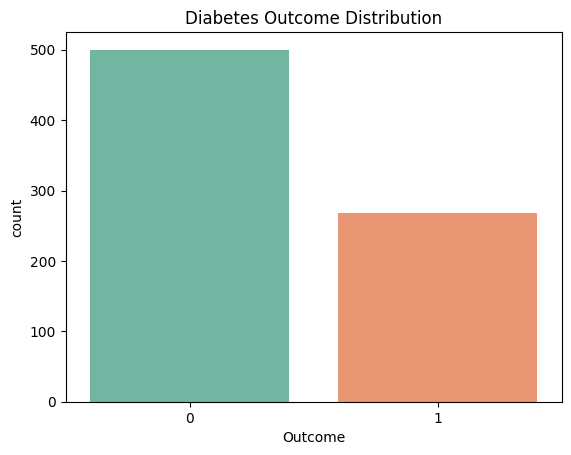

,proportion
Outcome,
0,0.651042
1,0.348958


In [11]:
# Exploratory Data Analysis (EDA)
# Outcome Distribution
sns.countplot(x='Outcome', data=df_clean, palette='Set2')
plt.title("Diabetes Outcome Distribution")
plt.show()

df_clean['Outcome'].value_counts(normalize=True)


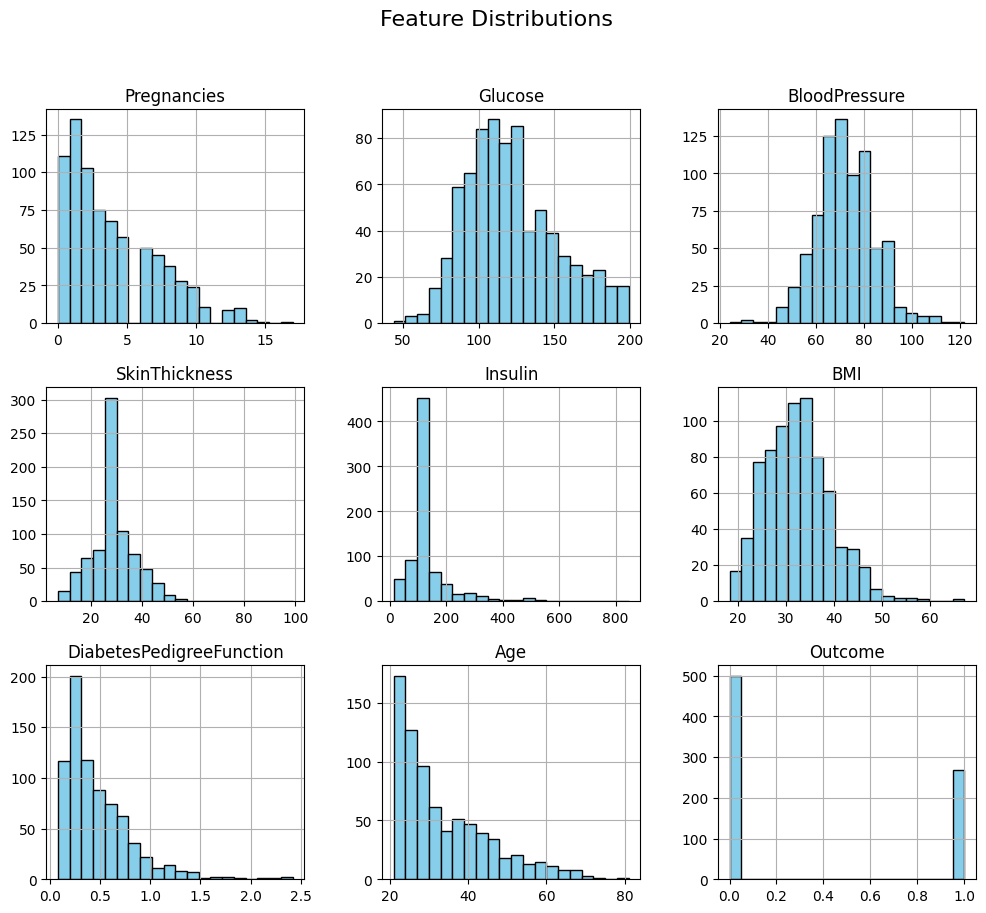

In [12]:
# Histograms for Each Feature
df_clean.hist(figsize=(12,10), bins=20, color='skyblue', edgecolor='black')
plt.suptitle("Feature Distributions", size=16)
plt.show()

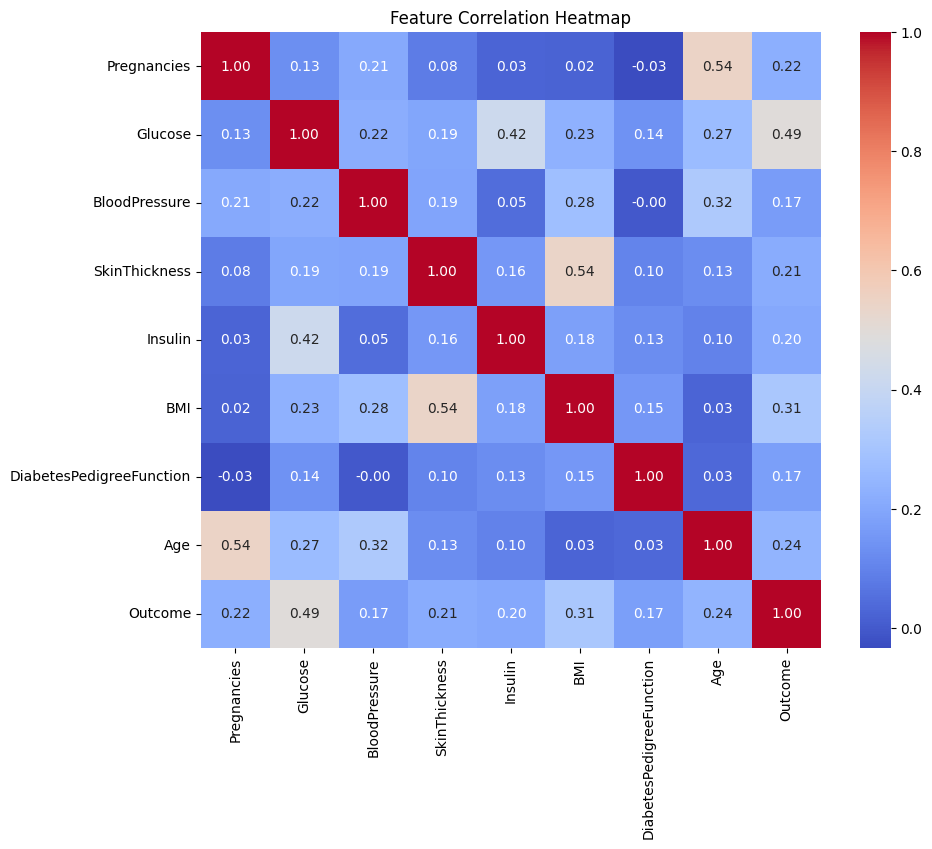

In [13]:
# Correlation Heatmap
plt.figure(figsize=(10,8))
sns.heatmap(df_clean.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Feature Correlation Heatmap")
plt.show()

/tmp/ipython-input-3629374349.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Outcome', y=col, data=df_clean, palette="Set3")
/tmp/ipython-input-3629374349.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Outcome', y=col, data=df_clean, palette="Set3")
/tmp/ipython-input-3629374349.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Outcome', y=col, data=df_clean, palette="Set3")
/tmp/ipython-input-3629374349.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign 

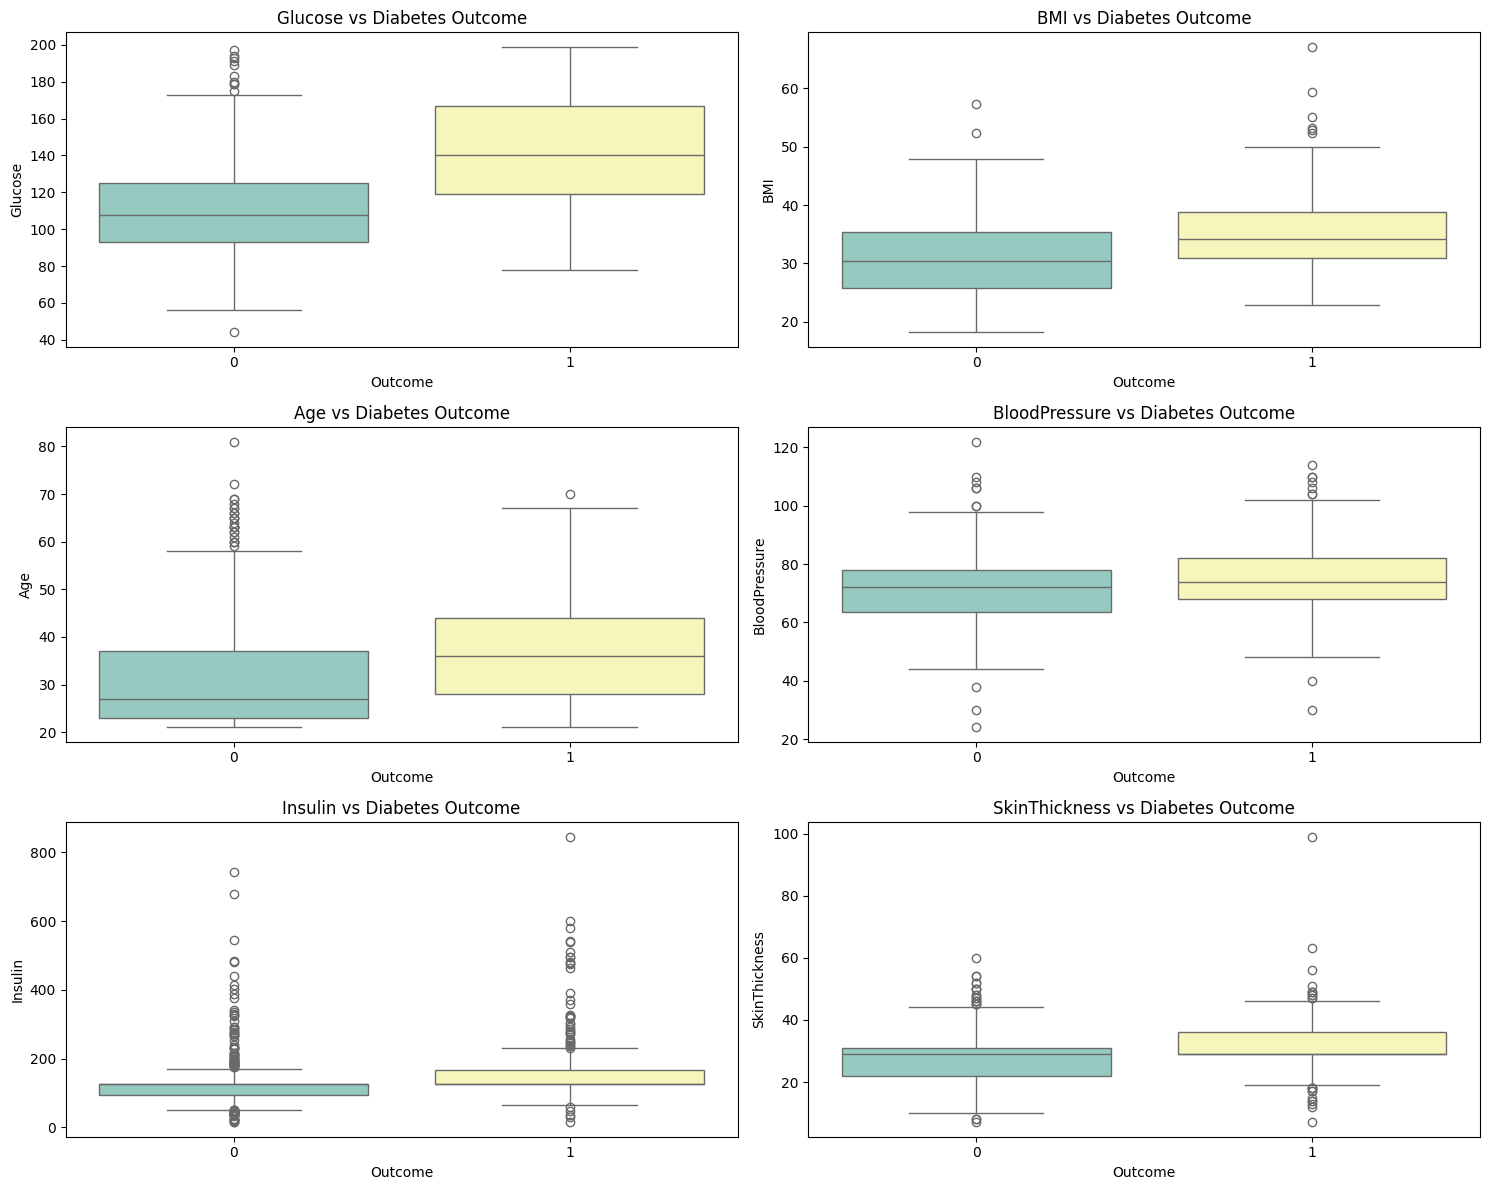

In [14]:
# Feature vs. Outcome Comparisons
features_to_plot = ['Glucose', 'BMI', 'Age', 'BloodPressure', 'Insulin', 'SkinThickness']

plt.figure(figsize=(15, 12))

for i, col in enumerate(features_to_plot, 1):
    plt.subplot(3, 2, i)
    sns.boxplot(x='Outcome', y=col, data=df_clean, palette="Set3")
    plt.title(f"{col} vs Diabetes Outcome")

plt.tight_layout()
plt.show()

In [15]:
# Feature Engineering + Train/Test Split.

In [16]:
X = df_clean.drop('Outcome', axis=1)
y = df_clean['Outcome']

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Training set shape:", X_train.shape)
print("Test set shape:", X_test.shape)


Training set shape: (614, 8)
Test set shape: (154, 8)


In [17]:
# Feature Scaling
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [18]:
# Logistic Regression (Baseline)

Logistic Regression Results:
Accuracy: 0.7077922077922078
Precision: 0.6
Recall: 0.5
F1 Score: 0.5454545454545454
ROC AUC: 0.812962962962963


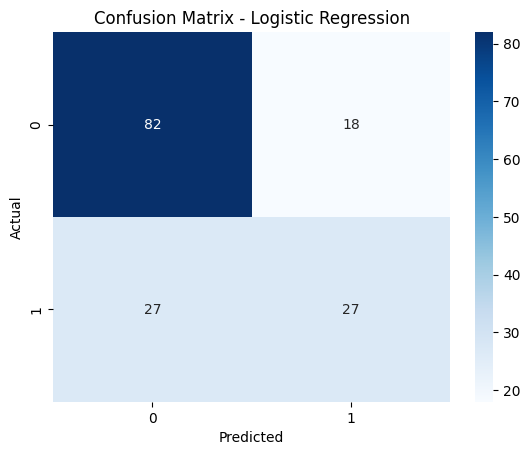


Classification Report:
               precision    recall  f1-score   support

           0       0.75      0.82      0.78       100
           1       0.60      0.50      0.55        54

    accuracy                           0.71       154
   macro avg       0.68      0.66      0.67       154
weighted avg       0.70      0.71      0.70       154



In [19]:
# Logistic Regression Baseline Model
log_reg = LogisticRegression(max_iter=1000, random_state=42)

log_reg.fit(X_train_scaled, y_train)
y_pred = log_reg.predict(X_test_scaled)
y_prob = log_reg.predict_proba(X_test_scaled)[:, 1]

# Evaluation
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report

print("Logistic Regression Results:")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_prob))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues")
plt.title("Confusion Matrix - Logistic Regression")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Classification Report
print("\nClassification Report:\n", classification_report(y_test, y_pred))


In [20]:
# K-Nearest Neighbors (KNN)

In [21]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=5)  # default k=5
knn.fit(X_train_scaled, y_train)

y_pred_knn = knn.predict(X_test_scaled)
y_prob_knn = knn.predict_proba(X_test_scaled)[:, 1]

print("KNN Results:")
print("Accuracy:", accuracy_score(y_test, y_pred_knn))
print("Precision:", precision_score(y_test, y_pred_knn))
print("Recall:", recall_score(y_test, y_pred_knn))
print("F1 Score:", f1_score(y_test, y_pred_knn))
print("ROC AUC:", roc_auc_score(y_test, y_prob_knn))

KNN Results:
Accuracy: 0.7532467532467533
Precision: 0.66
Recall: 0.6111111111111112
F1 Score: 0.6346153846153846
ROC AUC: 0.7886111111111112


In [22]:
# Decision Tree

In [23]:
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier(random_state=42, max_depth=5)  # limit depth to reduce overfitting
dt.fit(X_train, y_train)  # no scaling needed

y_pred_dt = dt.predict(X_test)
y_prob_dt = dt.predict_proba(X_test)[:, 1]

print("Decision Tree Results:")
print("Accuracy:", accuracy_score(y_test, y_pred_dt))
print("Precision:", precision_score(y_test, y_pred_dt))
print("Recall:", recall_score(y_test, y_pred_dt))
print("F1 Score:", f1_score(y_test, y_pred_dt))
print("ROC AUC:", roc_auc_score(y_test, y_prob_dt))


Decision Tree Results:
Accuracy: 0.7597402597402597
Precision: 0.639344262295082
Recall: 0.7222222222222222
F1 Score: 0.6782608695652174
ROC AUC: 0.7622222222222222


In [24]:
# Random Forest

In [25]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

y_pred_rf = rf.predict(X_test)
y_prob_rf = rf.predict_proba(X_test)[:, 1]

print("Random Forest Results:")
print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print("Precision:", precision_score(y_test, y_pred_rf))
print("Recall:", recall_score(y_test, y_pred_rf))
print("F1 Score:", f1_score(y_test, y_pred_rf))
print("ROC AUC:", roc_auc_score(y_test, y_prob_rf))


Random Forest Results:
Accuracy: 0.7792207792207793
Precision: 0.7272727272727273
Recall: 0.5925925925925926
F1 Score: 0.6530612244897959
ROC AUC: 0.8191666666666666


In [26]:
# XGBoost (Boosting)

In [27]:
xgb_model = xgb.XGBClassifier(
    n_estimators=200, learning_rate=0.05, max_depth=4, random_state=42, use_label_encoder=False, eval_metric='logloss'
)
xgb_model.fit(X_train, y_train)

y_pred_xgb = xgb_model.predict(X_test)
y_prob_xgb = xgb_model.predict_proba(X_test)[:, 1]

print("XGBoost Results:")
print("Accuracy:", accuracy_score(y_test, y_pred_xgb))
print("Precision:", precision_score(y_test, y_pred_xgb))
print("Recall:", recall_score(y_test, y_pred_xgb))
print("F1 Score:", f1_score(y_test, y_pred_xgb))
print("ROC AUC:", roc_auc_score(y_test, y_prob_xgb))

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [19:36:09] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost Results:
Accuracy: 0.7662337662337663
Precision: 0.6875
Recall: 0.6111111111111112
F1 Score: 0.6470588235294118
ROC AUC: 0.822037037037037


In [28]:
# Collect Results into a Table
# Collect all results
results = {
    "Model": ["Logistic Regression", "KNN", "Decision Tree", "Random Forest", "XGBoost"],
    "Accuracy": [
        accuracy_score(y_test, y_pred),
        accuracy_score(y_test, y_pred_knn),
        accuracy_score(y_test, y_pred_dt),
        accuracy_score(y_test, y_pred_rf),
        accuracy_score(y_test, y_pred_xgb)
    ],
    "Precision": [
        precision_score(y_test, y_pred),
        precision_score(y_test, y_pred_knn),
        precision_score(y_test, y_pred_dt),
        precision_score(y_test, y_pred_rf),
        precision_score(y_test, y_pred_xgb)
    ],
    "Recall": [
        recall_score(y_test, y_pred),
        recall_score(y_test, y_pred_knn),
        recall_score(y_test, y_pred_dt),
        recall_score(y_test, y_pred_rf),
        recall_score(y_test, y_pred_xgb)
    ],
    "F1 Score": [
        f1_score(y_test, y_pred),
        f1_score(y_test, y_pred_knn),
        f1_score(y_test, y_pred_dt),
        f1_score(y_test, y_pred_rf),
        f1_score(y_test, y_pred_xgb)
    ],
    "ROC AUC": [
        roc_auc_score(y_test, y_prob),
        roc_auc_score(y_test, y_prob_knn),
        roc_auc_score(y_test, y_prob_dt),
        roc_auc_score(y_test, y_prob_rf),
        roc_auc_score(y_test, y_prob_xgb)
    ]
}

results_df = pd.DataFrame(results)
results_df


,Model,Accuracy,Precision,Recall,F1 Score,ROC AUC
0,Logistic Regression,0.707792,0.600000,0.500000,0.545455,0.812963
1,KNN,0.753247,0.660000,0.611111,0.634615,0.788611
2,Decision Tree,0.759740,0.639344,0.722222,0.678261,0.762222
3,Random Forest,0.779221,0.727273,0.592593,0.653061,0.819167
4,XGBoost,0.766234,0.687500,0.611111,0.647059,0.822037


In [29]:
# Comparison table
results = {
    "Model": ["Logistic Regression", "KNN", "Decision Tree", "Random Forest", "XGBoost"],
    "Accuracy": [
        accuracy_score(y_test, y_pred),
        accuracy_score(y_test, y_pred_knn),
        accuracy_score(y_test, y_pred_dt),
        accuracy_score(y_test, y_pred_rf),
        accuracy_score(y_test, y_pred_xgb)
    ],
    "Precision": [
        precision_score(y_test, y_pred),
        precision_score(y_test, y_pred_knn),
        precision_score(y_test, y_pred_dt),
        precision_score(y_test, y_pred_rf),
        precision_score(y_test, y_pred_xgb)
    ],
    "Recall": [
        recall_score(y_test, y_pred),
        recall_score(y_test, y_pred_knn),
        recall_score(y_test, y_pred_dt),
        recall_score(y_test, y_pred_rf),
        recall_score(y_test, y_pred_xgb)
    ],
    "F1 Score": [
        f1_score(y_test, y_pred),
        f1_score(y_test, y_pred_knn),
        f1_score(y_test, y_pred_dt),
        f1_score(y_test, y_pred_rf),
        f1_score(y_test, y_pred_xgb)
    ],
    "ROC AUC": [
        roc_auc_score(y_test, y_prob),
        roc_auc_score(y_test, y_prob_knn),
        roc_auc_score(y_test, y_prob_dt),
        roc_auc_score(y_test, y_prob_rf),
        roc_auc_score(y_test, y_prob_xgb)
    ]
}

results_df = pd.DataFrame(results).sort_values("ROC AUC", ascending=False).reset_index(drop=True)
display(results_df)

results_df.to_csv("baseline_model_comparison.csv", index=False)

,Model,Accuracy,Precision,Recall,F1 Score,ROC AUC
0,XGBoost,0.766234,0.687500,0.611111,0.647059,0.822037
1,Random Forest,0.779221,0.727273,0.592593,0.653061,0.819167
2,Logistic Regression,0.707792,0.600000,0.500000,0.545455,0.812963
3,KNN,0.753247,0.660000,0.611111,0.634615,0.788611
4,Decision Tree,0.759740,0.639344,0.722222,0.678261,0.762222


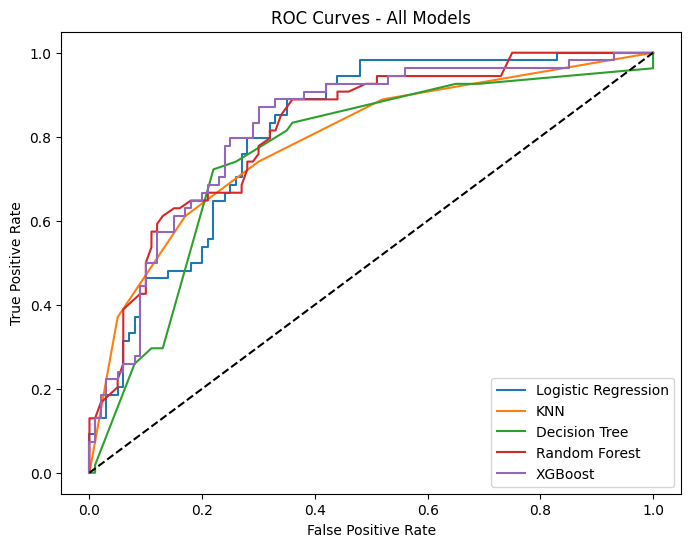

In [30]:
# ROC Curves for All Models
plt.figure(figsize=(8,6))

# Logistic Regression
fpr, tpr, _ = roc_curve(y_test, y_prob)
plt.plot(fpr, tpr, label="Logistic Regression")

# KNN
fpr, tpr, _ = roc_curve(y_test, y_prob_knn)
plt.plot(fpr, tpr, label="KNN")

# Decision Tree
fpr, tpr, _ = roc_curve(y_test, y_prob_dt)
plt.plot(fpr, tpr, label="Decision Tree")

# Random Forest
fpr, tpr, _ = roc_curve(y_test, y_prob_rf)
plt.plot(fpr, tpr, label="Random Forest")

# XGBoost
fpr, tpr, _ = roc_curve(y_test, y_prob_xgb)
plt.plot(fpr, tpr, label="XGBoost")

# Plot formatting
plt.plot([0,1],[0,1],'k--')  # baseline
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves - All Models")
plt.legend()
plt.show()

Best baseline by ROC AUC: XGBoost


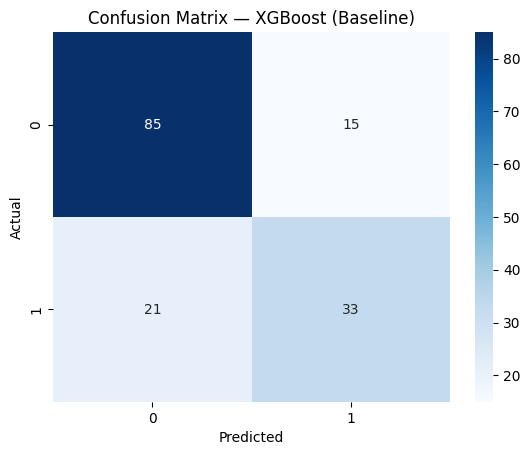

In [31]:
best_model_name = results_df.iloc[0]["Model"]
print("Best baseline by ROC AUC:", best_model_name)

pred_map = {
    "Logistic Regression": y_pred,
    "KNN": y_pred_knn,
    "Decision Tree": y_pred_dt,
    "Random Forest": y_pred_rf,
    "XGBoost": y_pred_xgb
}
cm = confusion_matrix(y_test, pred_map[best_model_name])

sns.heatmap(cm, annot=True, fmt='d', cmap="Blues")
plt.title(f"Confusion Matrix — {best_model_name} (Baseline)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


In [38]:
# Logistic Regression with Class Weights
log_reg_bal = LogisticRegression(max_iter=2000, class_weight='balanced', random_state=42)
log_reg_bal.fit(X_train_scaled, y_train)

y_pred_bal = log_reg_bal.predict(X_test_scaled)
y_prob_bal = log_reg_bal.predict_proba(X_test_scaled)[:, 1]

print("Balanced Logistic Regression")
print("Accuracy:", accuracy_score(y_test, y_pred_bal))
print("Precision:", precision_score(y_test, y_pred_bal))
print("Recall:", recall_score(y_test, y_pred_bal))
print("F1 Score:", f1_score(y_test, y_pred_bal))
print("ROC AUC:", roc_auc_score(y_test, y_prob_bal))

Balanced Logistic Regression
Accuracy: 0.7337662337662337
Precision: 0.6031746031746031
Recall: 0.7037037037037037
F1 Score: 0.6495726495726496
ROC AUC: 0.8125925925925926


In [39]:
# Hyperparameter Tuning (GridSearchCV)
param_grid_knn = {"n_neighbors": range(3, 21)}

grid_knn = GridSearchCV(KNeighborsClassifier(), param_grid_knn, cv=5, scoring="accuracy")
grid_knn.fit(X_train_scaled, y_train)

print("Best K for KNN:", grid_knn.best_params_)
print("Best CV Accuracy:", grid_knn.best_score_)

# Retrain best model
best_knn = grid_knn.best_estimator_
y_pred_knn_best = best_knn.predict(X_test_scaled)
y_prob_knn_best = best_knn.predict_proba(X_test_scaled)[:, 1]

Best K for KNN: {'n_neighbors': 20}
Best CV Accuracy: 0.776915900306544


In [40]:
# Random Forest Tuning
param_grid_rf = {
    "n_estimators": [100, 200, 300],
    "max_depth": [4, 6, 8, None],
    "min_samples_split": [2, 5, 10]
}

grid_rf = GridSearchCV(RandomForestClassifier(random_state=42), param_grid_rf, cv=5, scoring="accuracy")
grid_rf.fit(X_train, y_train)

print("Best RF Params:", grid_rf.best_params_)
print("Best CV Accuracy:", grid_rf.best_score_)

# Retrain best model
best_rf = grid_rf.best_estimator_
y_pred_rf_best = best_rf.predict(X_test)
y_prob_rf_best = best_rf.predict_proba(X_test)[:, 1]

Best RF Params: {'max_depth': 6, 'min_samples_split': 5, 'n_estimators': 300}
Best CV Accuracy: 0.7753032120485139


In [41]:
# XGBoost Tuning
param_grid_xgb = {
    "n_estimators": [100, 200, 300],
    "max_depth": [3, 4, 5],
    "learning_rate": [0.01, 0.05, 0.1]
}

grid_xgb = GridSearchCV(
    xgb.XGBClassifier(random_state=42, use_label_encoder=False, eval_metric="logloss"),
    param_grid_xgb, cv=5, scoring="accuracy"
)
grid_xgb.fit(X_train, y_train)

print("Best XGB Params:", grid_xgb.best_params_)
print("Best CV Accuracy:", grid_xgb.best_score_)

# Retrain best model
best_xgb = grid_xgb.best_estimator_
y_pred_xgb_best = best_xgb.predict(X_test)
y_prob_xgb_best = best_xgb.predict_proba(X_test)[:, 1]

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [19:44:25] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [19:44:25] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [19:44:25] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [19:44:25] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [19:44:25] WARNING: /w

Best XGB Params: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 300}
Best CV Accuracy: 0.7606690657070505


In [42]:
# Comparison Table for Tuned Models
improved_results = {
    "Model": ["Balanced Logistic Regression", "KNN (Tuned)", "Random Forest (Tuned)", "XGBoost (Tuned)"],
    "Accuracy": [
        accuracy_score(y_test, y_pred_bal),
        accuracy_score(y_test, y_pred_knn_best),
        accuracy_score(y_test, y_pred_rf_best),
        accuracy_score(y_test, y_pred_xgb_best)
    ],
    "Precision": [
        precision_score(y_test, y_pred_bal),
        precision_score(y_test, y_pred_knn_best),
        precision_score(y_test, y_pred_rf_best),
        precision_score(y_test, y_pred_xgb_best)
    ],
    "Recall": [
        recall_score(y_test, y_pred_bal),
        recall_score(y_test, y_pred_knn_best),
        recall_score(y_test, y_pred_rf_best),
        recall_score(y_test, y_pred_xgb_best)
    ],
    "F1 Score": [
        f1_score(y_test, y_pred_bal),
        f1_score(y_test, y_pred_knn_best),
        f1_score(y_test, y_pred_rf_best),
        f1_score(y_test, y_pred_xgb_best)
    ],
    "ROC AUC": [
        roc_auc_score(y_test, y_prob_bal),
        roc_auc_score(y_test, y_prob_knn_best),
        roc_auc_score(y_test, y_prob_rf_best),
        roc_auc_score(y_test, y_prob_xgb_best)
    ]
}

improved_df = pd.DataFrame(improved_results).sort_values("ROC AUC", ascending=False).reset_index(drop=True)
display(improved_df)

,Model,Accuracy,Precision,Recall,F1 Score,ROC AUC
0,XGBoost (Tuned),0.733766,0.644444,0.537037,0.585859,0.817963
1,Balanced Logistic Regression,0.733766,0.603175,0.703704,0.649573,0.812593
2,Random Forest (Tuned),0.740260,0.666667,0.518519,0.583333,0.810000
3,KNN (Tuned),0.759740,0.697674,0.555556,0.618557,0.807130


In [48]:
# Save comparison tables
results_df.to_csv("baseline_model_comparison.csv", index=False)
improved_df.to_csv("tuned_model_comparison.csv", index=False)

# (Optional) Save the tuned best model
import joblib
# choose whichever was best
joblib.dump(best_xgb, "best_model_xgboost.pkl")  # or best_rf, etc.

# Export requirements (good enough for Colab env)
!pip freeze > requirements.txt
